# Maximum Likelihood Estimation (MLE) and Maximum a Posteriori (MAP)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
from tqdm import tqdm
from scipy.stats import poisson

1) Define a test problem in the following way:

- Let the user fix a positive integer $K > 0$, and define $θ_{true} = (1, 1, . . . , 1)^T$ (you can also consider different $θ_{true}$);

-  Define an input dataset
$$X = [x^1, x^2, ..., x^N] ∈ ℝ^N$$
where the $x^i$ are N uniformly distributed datapoints in the interval $[a, b]$, where $a < b$ are value that the user can select;

- Given a set of functions ${φ_1, φ_2, ..., φ_K}$, define the Generalized Vandermonde matrix $Φ(X)∈ℝ^{N×K}$, whose element in position $(i, j)$ is $φ_j(x^i)$. In particular, write a function defining the classical Vandermonde matrix where $φ_j(x) = x^{j−1}$;

- Given a variance $σ^2 > 0$ defined by the user, compute $$Y = Φ(X)θ_{true} + e$$ where $e ∼ \mathcal{N} (0, σ^2I)$ is Gaussian distributed noise with variance $σ^2$. Note that the test problem
defined in this way is very similar to what we did to define a test problem in the first Lab.

In [ ]:
def split(X, Y, N_train):
  indexes = np.arange(len(X))
  np.random.shuffle(indexes)
  train_idxs = indexes[:N_train]
  test_idxs = indexes[N_train:]

  return X[train_idxs], Y[train_idxs], X[test_idxs], Y[test_idxs]


def vander(X, K):
  return np.vander(X, K, increasing=True)


def create_dataset(N, K, train_size=0.8, a=0, b=1, variance=0.4):
  theta_true = np.ones((K,))

  X = np.random.uniform(low=a, high=b, size=N) # np.linspace(a, b, N)
  phi = vander(X, K)

  N_train = round(N*train_size)
  noise = np.random.normal(0, variance, N)
  Y = (phi @ theta_true) + noise

  X_train, Y_train, X_test, Y_test = split(X, Y, N_train)

  return X_train, Y_train, X_test, Y_test


In [ ]:
def f_MLE(theta, K, X, Y):
  return 1/2 * np.linalg.norm(vander(X, K) @ theta - Y, 2)**2

def grad_f_MLE(theta, K, X, Y):
  return vander(X, K).T @ (((vander(X, K))@theta) - Y)

def f_MAP(lam):
  return lambda theta, K, X, Y: 0.5 * ((np.linalg.norm(vander(X, K)@theta - Y)**2) + (lam/2) * np.linalg.norm(theta)**2)

def grad_f_MAP(lam):
  return lambda theta, K, X, Y: vander(X, K).T @ ((vander(X, K) @ theta) - Y) + 2 * lam * theta

In [ ]:
def backtracking(f, grad_f, theta, K, X, Y):
    alpha = 1
    c = 0.8
    tau = 0.25

    while f(theta - alpha * grad_f(theta, K, X, Y), K, X, Y) > f(theta, K, X, Y) - c * alpha * np.linalg.norm(grad_f(theta, K, X, Y)) ** 2:
        alpha = tau * alpha

        if alpha < 1e-3:
            break
    return alpha


def GD(t0, D, K, tolf, tolx, max_iterations, backtrack, alpha, f, grad_f, lambd = None):
  (X, Y) = D

  if lambd is not None:
    f = f(lambd)
    grad_f = grad_f(lambd)

  tk = t0
  f_vals = [f(t0, K, X, Y)]
  grad_vals = [grad_f(t0, K, X, Y)]
  err_vals = [np.linalg.norm(grad_f(t0, K, X, Y))]
  t_vals = [t0]

  iteration = 0

  stop_criteria_1 = float('inf')   # ||||∇f(x_k)|||| / ||||∇f(x_0)|||| < tolf
  stop_criteria_2 = float('inf')   # ||||x_k - x_k - 1|||| < tolx

  while (stop_criteria_1 >= tolf and stop_criteria_2 >= tolx) and (iteration < max_iterations - 1):
    t_prec = tk
    if backtrack:
      alpha = backtracking(f, grad_f, tk, K, X, Y)

    step = alpha*grad_f(tk, K, X, Y)
    tk = tk - step

    t_vals.append(tk)
    f_vals.append(f(tk, K, X, Y))
    grad_vals.append(grad_f(tk, K, X, Y))
    err_vals.append(np.linalg.norm(grad_f(tk, K, X, Y)))

    stop_criteria_1 = np.linalg.norm(grad_f(tk, K, X, Y)) / np.linalg.norm(grad_f(t0, K, X, Y))
    stop_criteria_2 = np.linalg.norm(tk - t_prec, 2)

    iteration += 1

  return tk


def get_batch_indexes(batch_size, tot_batch, N):
    batch_indexes = np.arange(N)
    np.random.shuffle(batch_indexes)

    idx = []

    for i in range(0, tot_batch * batch_size, batch_size):
        idx.append(batch_indexes[i:i + batch_size].tolist())

    return idx

def SGD(t0, D, K, batch_size, n_epochs, alpha, f, grad_f, lambd = None):
    X, Y = D
    X, Y = np.array(X), np.array(Y)
    N = len(X)

    if lambd is not None:
      f = f(lambd)
      grad_f = grad_f(lambd)

    n_batch_per_epoch = math.ceil(N/batch_size)
    tot_batches = n_batch_per_epoch * n_epochs

    t_vals = [t0]
    f_vals = [f(t0, K, X, Y)]
    grad_f_vals = [grad_f(t0, K, X, Y)]
    err_vals = [np.linalg.norm(grad_f(t0, K, X, Y))]

    for epoch in range(n_epochs):
        batch_indexes = get_batch_indexes(batch_size, tot_batches, N)

        for b in range(n_batch_per_epoch):
            X_batch, Y_batch = X[batch_indexes[b]], Y[batch_indexes[b]]

            t = t_vals[-1] - alpha * grad_f(t_vals[-1], K, X_batch, Y_batch)
            t_vals.append(t)

        f_vals.append(f(t, K, X_batch, Y_batch))
        grad_f_vals.append(grad_f(t, K, X_batch, Y_batch))
        err_vals.append(np.linalg.norm(grad_f(t, K, X_batch, Y_batch)))

    return t_vals[-1]


def predict(x, theta, k):
  phi = vander(x, k)
  return phi @ theta


def plot_regression_model_mle(D, K, theta, a=0, b=1, points=100, plot_test_set=False, T=(), title=""):
    Xtrain,Ytrain = D

    plt.title(title)
    plt.plot(Xtrain, Ytrain, "ro", markersize=3)
    if plot_test_set:
        Xtest,Ytest = T
        plt.plot(Xtest,Ytest,"bo", markersize=3)
        plt.legend(["Training set","Test set"])

    XX = np.linspace(a,b,points)
    YY = vander(XX,K) @ theta
    plt.plot(XX, YY)
    plt.grid()
    plt.show()


def plot_regression_model_map(D, K, theta, a=0, b=1, points=100, plot_test_set=False, T=(), lam=[], title=""):
    Xtrain,Ytrain = D

    plt.plot(Xtrain,Ytrain,"ro", markersize=3)
    if plot_test_set:
        Xtest,Ytest = T
        plt.plot(Xtest,Ytest,"bo", markersize=3)
        if(len(lam) > 0):
            for l in lam:
                theta_map = map(D, K, l, type="normal")
                XX = np.linspace(a,b,points)
                YY = vander(XX,K) @ theta_map
                plt.plot(XX, YY)
            plt.legend(["Train set","Test set"]+lam)
        else:
            XX = np.linspace(a,b,points)
            YY = vander(XX,K) @ theta
            plt.plot(XX, YY)
            plt.legend(["Train set","Test set"])
    else:
        XX = np.linspace(a,b,points)
        YY = vander(XX,K) @ theta
        plt.plot(XX, YY)

    plt.title(title)
    plt.grid()
    plt.show()


In [ ]:
def plot_error_heatmaps_mle(errors_normeq, errors_gd, errors_sgd, same_colorbar: True):
  if same_colorbar:
    plot_error_heatmaps_mle_same_colorbar(errors_normeq, errors_gd, errors_sgd)
  else:
    plot_error_heatmaps_mle_independent_colorbar(errors_normeq, errors_gd, errors_sgd)

#same color bar (not very useful because normEQ have always a very high error)
def plot_error_heatmaps_mle_same_colorbar(errors_normeq, errors_gd, errors_sgd):
    errors_by_method = {"NormEQ": errors_normeq, "GD": errors_gd, "SGD": errors_sgd}
    optimization_methods = list(errors_by_method.keys())
    num_methods = len(optimization_methods)

    # Determine the global min and max error values
    global_min = min(min(min(errors_by_method[method][N][k] for k in K_to_test) for N in N_to_test) for method in optimization_methods)
    global_max = max(max(max(errors_by_method[method][N][k] for k in K_to_test) for N in N_to_test) for method in optimization_methods)

    # Create a row of subplots
    fig, axes = plt.subplots(1, num_methods, figsize=(num_methods * 5, 4))

    for idx, opt_method_name in enumerate(optimization_methods):
        ax = axes[idx]
        mle_errors = np.array([[errors_by_method[opt_method_name][N][k] for k in K_to_test] for N in N_to_test])
        sns.heatmap(mle_errors, ax=ax, annot=True, xticklabels=K_to_test, yticklabels=N_to_test, cmap="viridis", vmin=global_min, vmax=global_max)
        ax.set_title(f"{opt_method_name} - MLE Errors")
        ax.set_xlabel("K_test")
        if idx == 0:
            ax.set_ylabel("N_test")

    plt.tight_layout()
    plt.show()


def plot_error_heatmaps_mle_independent_colorbar(errors_normeq, errors_gd, errors_sgd):
    errors_by_method = {"NormEQ": errors_normeq, "GD": errors_gd, "SGD": errors_sgd}
    optimization_methods = list(errors_by_method.keys())
    num_methods = len(optimization_methods)

    # Create a row of subplots
    fig, axes = plt.subplots(1, num_methods, figsize=(num_methods * 5, 4))

    for idx, opt_method_name in enumerate(optimization_methods):
        ax = axes[idx]
        mle_errors = np.array([[errors_by_method[opt_method_name][N][k] for k in K_to_test] for N in N_to_test])
        sns.heatmap(mle_errors, ax=ax, annot=True, xticklabels=K_to_test, yticklabels=N_to_test, cmap="viridis")
        ax.set_title(f"{opt_method_name} - MLE Errors")
        ax.set_xlabel("K_test")
        if idx == 0:
            ax.set_ylabel("N_test")

    plt.tight_layout()
    plt.show()

def plot_error_heatmaps_map(errors_normeq, errors_gd, errors_sgd, lambda_to_test, same_colorbar: True):
  if same_colorbar:
    plot_error_heatmaps_map_same_colorbar(errors_normeq, errors_gd, errors_sgd, lambda_to_test)
  else:
    plot_error_heatmaps_map_independent_colorbar(errors_normeq, errors_gd, errors_sgd, lambda_to_test)

#same color bar (not very useful because normEQ have always a very high error)
def plot_error_heatmaps_map_same_colorbar(errors_normeq, errors_gd, errors_sgd, lambda_to_test):
    errors_by_method = {"NormEQ": errors_normeq, "GD": errors_gd, "SGD": errors_sgd}
    optimization_methods = list(errors_by_method.keys())
    num_lambda = len(lambda_to_test)
    num_methods = len(optimization_methods)

    # Determine the global min and max error values
    global_min = min(min(min(errors_by_method[method][N][k][l] for l in lambda_to_test) for k in K_to_test) for N in N_to_test for method in optimization_methods)
    global_max = max(max(max(errors_by_method[method][N][k][l] for l in lambda_to_test) for k in K_to_test) for N in N_to_test for method in optimization_methods)

    # Create a grid of subplots
    fig, axes = plt.subplots(num_methods, num_lambda, figsize=(num_lambda * 6, num_methods * 4))

    for method_idx, opt_method_name in enumerate(optimization_methods):
        for idx, l in enumerate(lambda_to_test):
            ax = axes[method_idx, idx] if num_methods > 1 else axes[idx]

            map_errors = np.array([[errors_by_method[opt_method_name][N][k][l] for k in K_to_test] for N in N_to_test])
            sns.heatmap(map_errors, ax=ax, annot=True, xticklabels=K_to_test, yticklabels=N_to_test, cmap="viridis", vmin=global_min, vmax=global_max)
            ax.set_title(f"{opt_method_name} - MAP Errors (Lambda={l})")
            ax.set_xlabel("K_test")
            if idx == 0:
                ax.set_ylabel("N_test")

    plt.tight_layout()
    plt.show()

#independent color bar for each heatmap
def plot_error_heatmaps_map_independent_colorbar(errors_normeq, errors_gd, errors_sgd, lambda_to_test):
    errors_by_method = {"NormEQ": errors_normeq, "GD": errors_gd, "SGD": errors_sgd}
    optimization_methods = list(errors_by_method.keys())
    num_lambda = len(lambda_to_test)
    num_methods = len(optimization_methods)

    # Create a grid of subplots
    fig, axes = plt.subplots(num_methods, num_lambda, figsize=(num_lambda * 6, num_methods * 4))

    for method_idx, opt_method_name in enumerate(optimization_methods):
        for idx, l in enumerate(lambda_to_test):
            ax = axes[method_idx, idx] if num_methods > 1 else axes[idx]

            map_errors = np.array([[errors_by_method[opt_method_name][N][k][l] for k in K_to_test] for N in N_to_test])
            sns.heatmap(map_errors, ax=ax, annot=True, xticklabels=K_to_test, yticklabels=N_to_test, cmap="viridis")
            ax.set_title(f"{opt_method_name} - MAP Errors (Lambda={l})")
            ax.set_xlabel("K_test")
            if idx == 0:
                ax.set_ylabel("N_test")

    plt.tight_layout()
    plt.show()


def plot_test_vs_training_error(test_errors, training_errors, K_to_test, optimal_K, l = None):
  plt.grid()
  if l is not None:
    title = f"Absolute errors for different K (optimal is {K}), lambda={l}"
  else:
    title = f"Absolute errors for different K (optimal is {K})"

  plt.xlabel("K")
  plt.ylabel("Error")
  plt.title(title)
  plt.plot(K_to_test, test_errors, label="Errors on test set")
  plt.plot(K_to_test, training_errors, label="Errors on training set")
  plt.legend()
  plt.show()

## Dataset Creation

2) We now built a dataset $D = {(X, Y )}$ such that $θ_{true} = (1, 1, . . . , 1)^T ∈ ℝ^K$ is the best solution to the
least squares problem

$$Φ(X)θ ≈ Y$$

In [ ]:
K = 6                 #int(input("Choose the value for K: "))
a = 0                 #int(input("Choose the value for a: "))
b = 1                 #int(input("Choose the value for b: "))
sigma_square = 0.3    #float(input("Choose the value for sigma^2: "))

N = 100

theta_true = np.ones((K,))
X_train, Y_train, X_test, Y_test = create_dataset(N, K, variance = sigma_square)

3) Pretend not to know the correct value of K. The first task is to try to guess it and use it to approximate the true solution $θ_{true}$ by MLE and MAP. To do that:
- Write a function that takes as input the training data $D = (X, Y )$ and K and returns the MLE solution (with Gaussian assumption) $θ_{MLE} ∈ ℝ^K$  for that problem. Note that the loss function can be optimized by GD, SGD or Normal Equations.
- Write a function that takes as input a set of K-dimensional parameter vector $θ$ and a test set $𝓣 ℇ = {(X_{test}, Y_{test})}$ and returns the average absolute error of the polynomial regressor $f_θ(x)$
over X_test, computed as:
$$ \frac{1}{N_{test}}||{f_θ(X_{test}) − Y_{test}}||_2^2$$

In [ ]:
def MLE_solution(D, k, optimization_method, f, grad_f, gd_parameters = None, sgd_parameters = None):
  x, y = D
  phi = vander(x, k)

  # solve with normal equations
  if optimization_method == 0:
    theta_MLE = np.linalg.solve(phi.T @ phi, phi.T @ y)

  # solve with gradient descent
  elif optimization_method == 1:
    theta_MLE = GD(t0=np.zeros((k,)),
                   D=D,
                   K=k,
                   f=f,
                   grad_f=grad_f,
                   tolf=gd_parameters["tolf"],
                   tolx=gd_parameters["tolx"],
                   max_iterations=gd_parameters["max_iterations"],
                   alpha=gd_parameters["alpha"],
                   backtrack=gd_parameters["backtrack"])

  # solve with sthocastic gradient descent
  else:
   theta_MLE = SGD(t0=np.zeros((k,)),
                   D=D,
                   K=k,
                   f=f,
                   grad_f=grad_f,
                   batch_size=sgd_parameters["batch_size"],
                   n_epochs=sgd_parameters["n_epochs"],
                   alpha=sgd_parameters["alpha"])

  return theta_MLE


def abs_error(D, K, theta):
    X, Y = D
    N = len(X)
    phi = vander(X,K)
    return 1/N * np.linalg.norm((phi@theta) - Y,2)**2


## MLE regression model

- For different values of K, plot the training datapoints and the test datapoints with different colors, and visualize (as a continuous line) the learnt regression model $f_{θ_{MLE}}(x)$. Comment the results.


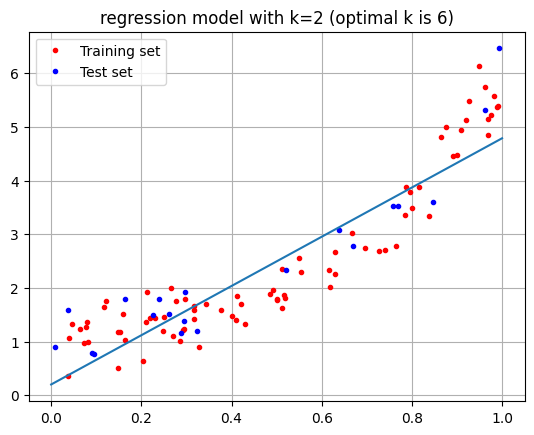

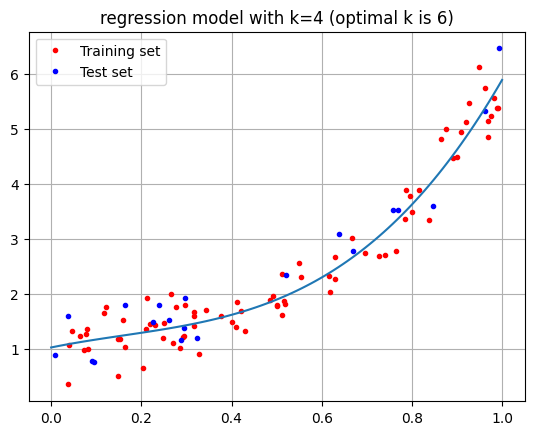

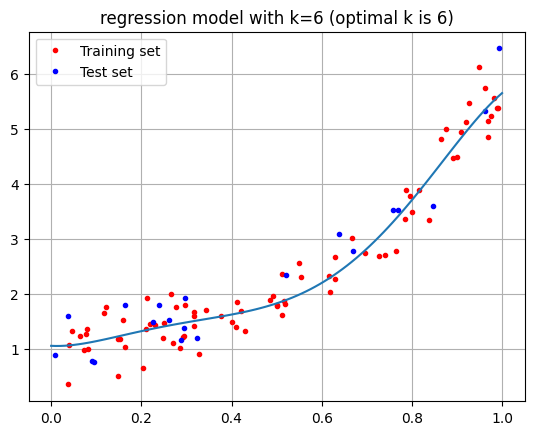

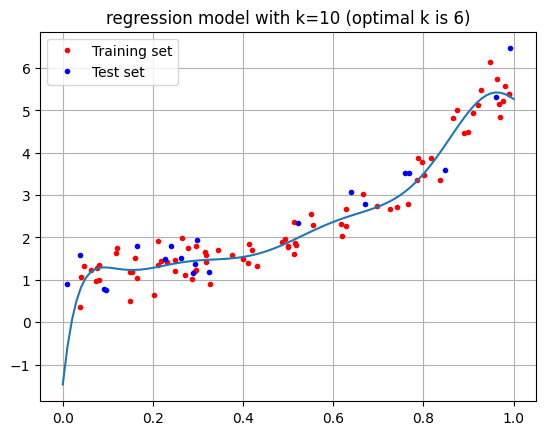

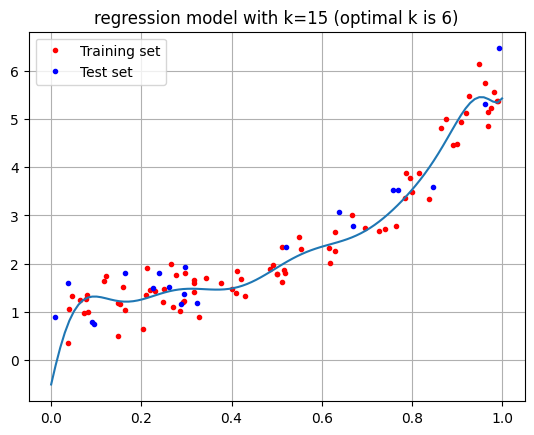

In [ ]:
optimization_method = {"NormEQ": 0, "GD": 1, "SGD": 2}
GD_parameters = {"tolf": 1e-20, "tolx": 1e-20, "max_iterations": 100, "alpha": 1e-2, "backtrack": False}
SGD_parameters = {"batch_size": 10, "n_epochs": 20, "alpha": 1e-2}


K_to_test = [2, 4, 6, 10, 15]
plot_test_set = True
opt_method = optimization_method["NormEQ"]

for k_test in K_to_test:
  theta_test = MLE_solution((X_train, Y_train), k=k_test, optimization_method=opt_method, f=f_MLE, grad_f=grad_f_MLE, gd_parameters=GD_parameters, sgd_parameters=SGD_parameters)
  plot_regression_model_mle((X_train, Y_train), k_test, theta_test, a=a, b=b, points=N, plot_test_set=plot_test_set, T=(X_test, Y_test), title=f"regression model with k={k_test} (optimal k is {K})")
  print()

For increasing values of K, use the functions defined above to compute the training and test error, where the test set is generated by sampling $N_{test}$ new points on the same interval $[a, b]$ of the training set and generating the corresponding $Y_{test}$ with the same procedure of the training set. Plot the two errors with respect to $K$. Comment the results.

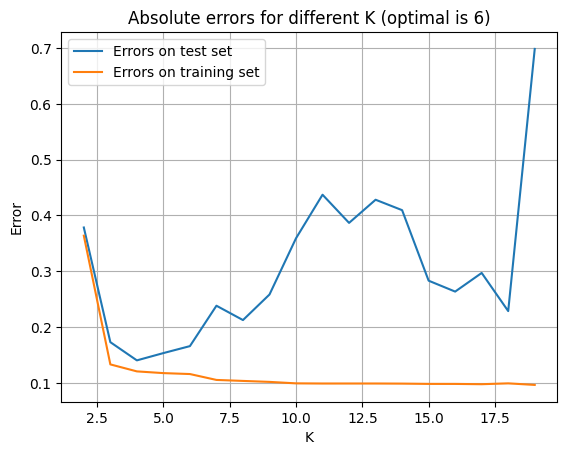

In [ ]:
optimization_method = {"NormEQ": 0, "GD": 1, "SGD": 2}
GD_parameters = {"tolf": 1e-5, "tolx": 1e-5, "max_iterations": 100, "alpha": 1e-2, "backtrack": True}
SGD_parameters = {"batch_size": 5, "n_epochs": 15, "alpha": 1e-2}


K_to_test = range(2,20)
opt_method = optimization_method["NormEQ"]

training_errors = []
test_errors = []

for k_test in K_to_test:
  theta_test = MLE_solution((X_train, Y_train), k=k_test, optimization_method=opt_method, f=f_MLE, grad_f=grad_f_MLE, gd_parameters=GD_parameters, sgd_parameters=SGD_parameters)

  test_errors.append(abs_error((X_test, Y_test), k_test, theta_test))
  training_errors.append(abs_error((X_train, Y_train), k_test, theta_test))

plot_test_vs_training_error(test_errors, training_errors, K_to_test, K)

As predicted, the best trade-off between error on test and training set is situated in correspondence of small K values, since the data was created in this way. For higher values of K, the plot shows higher error on the test set, while the overall trend of the training error seems to be decreasing, a clear signal that the regression model is overfitting.




- Write a function that takes as input the training data $D = (X, Y)$, $K$ and $λ > 0$ and returns
the MAP solution (with Gaussian assumption) $θ_{MAP} ∈ ℝ^K$ for that problem. Note that the loss
function can be optimized by GD, SGD or Normal Equations.

- For K lower, equal and greater than the correct degree of the test polynomial, plot the training
datapoints and the test datapoints with different colors, and visualize (as a continuous line) the
learnt regression model $f_{θ_{MAP}}(x)$ with different values of λ. Comment the results.

## MAP regression model

In [ ]:
def MAP_solution(D, k, lambd, optimization_method=0, f=None, grad_f=None, gd_parameters = None, sgd_parameters = None):
  x, y = D
  phi = vander(x, k)

  # solve with normal equations
  if optimization_method == 0:
    theta_MAP = np.linalg.inv(phi.T @ phi + lambd * np.identity(k , dtype="int")) @  phi.T @ y

  # solve with gradient descent
  elif optimization_method == 1:
    theta_MAP = GD(t0=np.zeros((k,)), D=D, K=k, f=f_MAP, grad_f=grad_f_MAP,
                   tolf=gd_parameters["tolf"],
                   tolx=gd_parameters["tolx"],
                   max_iterations=gd_parameters["max_iterations"],
                   alpha=gd_parameters["alpha"],
                   backtrack=gd_parameters["backtrack"],
                   lambd = lambd)

  # solve with sthocastic gradient desent
  elif optimization_method == 2:
    theta_MAP = SGD(t0=np.zeros((k,)), D=D, K=k, f=f, grad_f=grad_f,
                   batch_size=sgd_parameters["batch_size"],
                   n_epochs=sgd_parameters["n_epochs"],
                   alpha=sgd_parameters["alpha"],
                   lambd = lambd)
  return theta_MAP


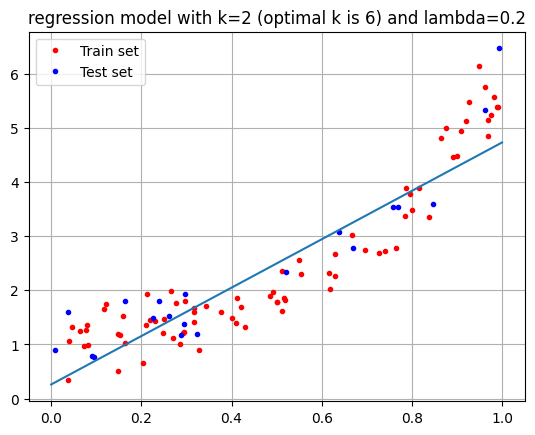

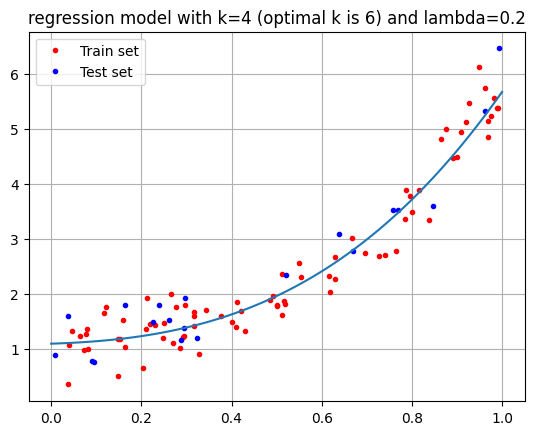

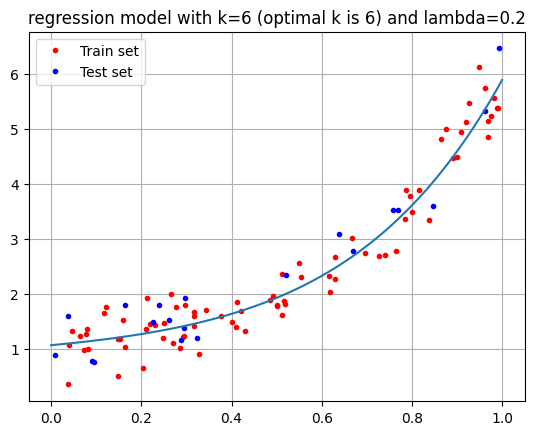

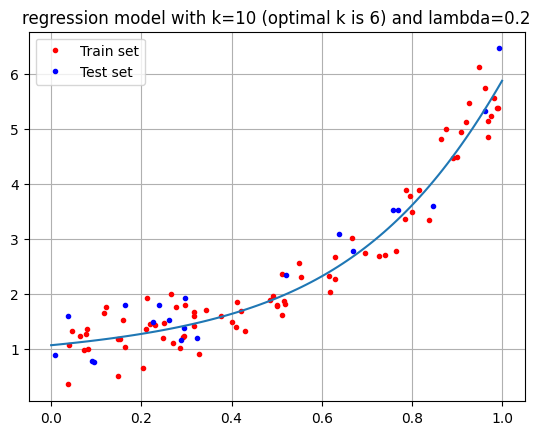

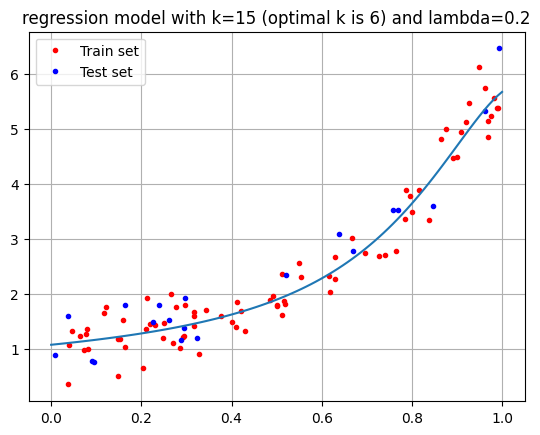

In [ ]:
optimization_method = {"NormEQ": 0, "GD": 1, "SGD": 2}
GD_parameters = {"tolf": 1e-6, "tolx": 1e-6, "max_iterations": 100, "alpha": 1e-2, "backtrack": True}
SGD_parameters = {"batch_size": 5, "n_epochs": 15, "alpha": 1e-2}

lambda_to_test = [0.2]
K_to_test = [2, 4, 6, 10, 15]
plot_test_set = True
opt_method = optimization_method["NormEQ"]


for k_test in K_to_test:
  for l in lambda_to_test:
    theta_test = MAP_solution((X_train, Y_train), k=k_test, lambd=l, optimization_method=opt_method, f=f_MAP, grad_f=grad_f_MAP, gd_parameters=GD_parameters, sgd_parameters=SGD_parameters)
    plot_regression_model_map((X_train, Y_train), k_test, theta_test, a=a, b=b, points=N, plot_test_set=plot_test_set, T=(X_test, Y_test), title=f"regression model with k={k_test} (optimal k is {K}) and lambda={l}")


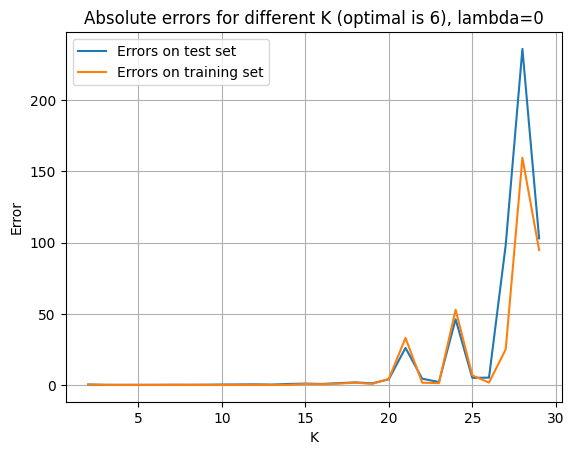

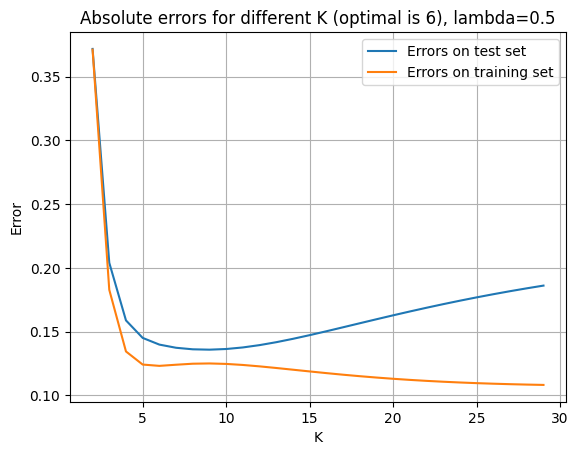

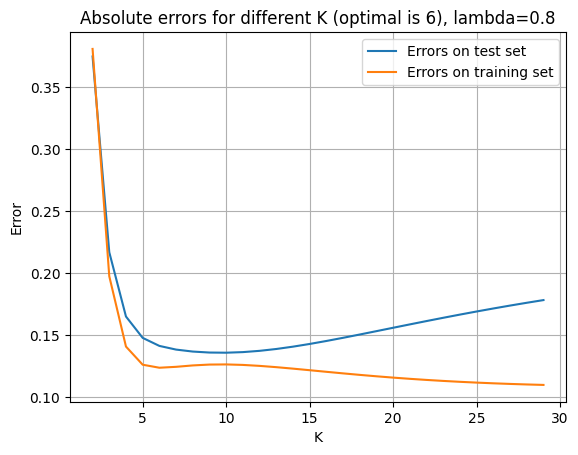

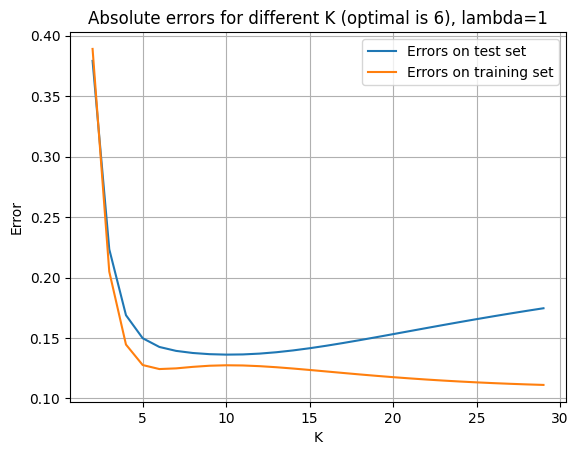

In [ ]:
optimization_method = {"NormEQ": 0, "GD": 1, "SGD": 2}
GD_parameters = {"tolf": 1e-5, "tolx": 1e-5, "max_iterations": 100, "alpha": 1e-2, "backtrack": True}
SGD_parameters = {"batch_size": 5, "n_epochs": 15, "alpha": 1e-2}

lambda_to_test = [0, 0.5, 0.8, 1]
K_to_test = range(2,30)
plot_test_set = True
opt_method = optimization_method["NormEQ"]


for l in lambda_to_test:
  test_errors = []
  training_errors = []
  for k_test in K_to_test:
    theta_test = MAP_solution((X_train, Y_train), k=k_test, lambd=l, optimization_method=opt_method, f=f_MAP, grad_f=grad_f_MAP, gd_parameters=GD_parameters, sgd_parameters=SGD_parameters)

    test_errors.append(abs_error((X_test, Y_test), k_test, theta_test))
    training_errors.append(abs_error((X_train, Y_train), k_test, theta_test))

  plot_test_vs_training_error(test_errors, training_errors, K_to_test, K, l)
  print()

MLE and MAP with $K=0$ are fundamentally the same in terms of their formulation and stability, in fact, from the first plot we can notice a similar trend to the one already showed in MLE: both exhibit significant overfitting, characterized by rapidly increasing error values as K becomes larger.

Conversely, selecting a non-zero value for the regularization term in MAP leads to a notably different trend. The increase in error with higher values of K is much more gradual (in this specific case, all the values of lambda showed similar, if not identical, results)

## MLE VS MAP comparison

- For K being way greater than the correct degree of the polynomial, compute the MLE and MAP
solution. Compare the test error of the two, for different values of λ (in the case of MAP).


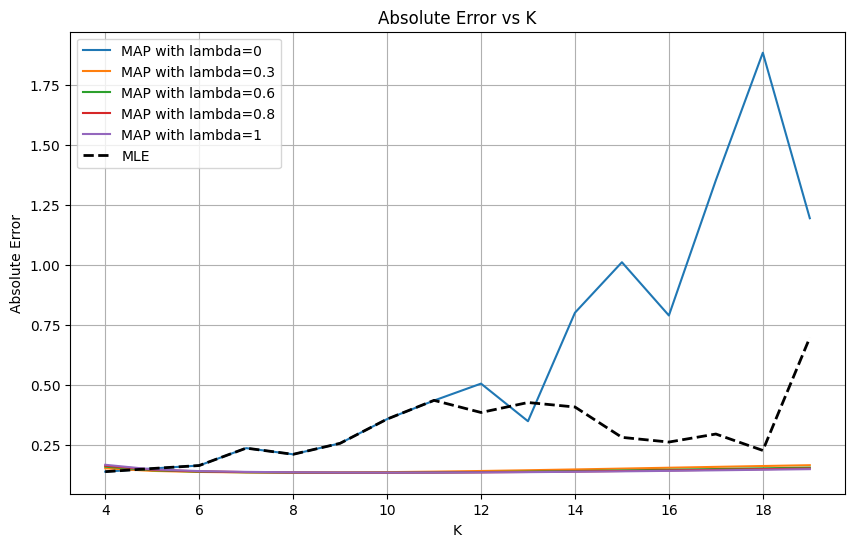

In [ ]:
optimization_method = {"NormEQ": 0, "GD": 1, "SGD": 2}
GD_parameters = {"tolf": 1e-5, "tolx": 1e-5, "max_iterations": 100, "alpha": 1e-2, "backtrack": True}
SGD_parameters = {"batch_size": 5, "n_epochs": 15, "alpha": 1e-2}

opt_method = optimization_method["NormEQ"]
lambda_to_test = [0, 0.3, 0.6, 0.8, 1]
K_to_test = range(4,20)
errors_map = {l: [] for l in lambda_to_test}
errors_mle = []

for k_test in K_to_test:
    theta_mle = MLE_solution((X_train, Y_train), k=k_test, optimization_method=opt_method, f=f_MLE, grad_f=grad_f_MLE, gd_parameters=GD_parameters, sgd_parameters=SGD_parameters)
    errors_mle.append(abs_error((X_test, Y_test), k_test, theta_mle))

    for l in lambda_to_test:
        theta_map = MAP_solution((X_train, Y_train), k=k_test, lambd=l, optimization_method=opt_method, f=f_MAP, grad_f=grad_f_MAP, gd_parameters=GD_parameters, sgd_parameters=SGD_parameters)
        errors_map[l].append(abs_error((X_test, Y_test), k_test, theta_map))

# Plotting
plt.figure(figsize=(10, 6))
for l, errors in errors_map.items():
    plt.plot(K_to_test, errors, label=f'MAP with lambda={l}')

plt.plot(K_to_test, errors_mle, label='MLE', color='black', linewidth=2, linestyle='--')
plt.title('Absolute Error vs K')
plt.xlabel('K')
plt.ylabel('Absolute Error')
plt.legend()
plt.grid(True)
plt.show()

As already observed, MLE and MAP with $λ=0$ are mathematically very similar, in fact they show the same trend, while MAP with $λ>0$ shows gradual increments of the error for higher values of $K$

- For K greater than the true degree of the polynomial, define $Err(θ) = \frac{||θ−θ_{true}||_2}
{||θ_{true}||_2}$ where $θ_{true}$ has been padded with zeros to match the shape of θ. Compute $Err(θ_{MLE})$ and $Err(θ_{MAP})$ for
increasing values of K and different values of λ.

- Compare the results obtained by increasing the number N of datapoints.

- Compare the results obtained by the three algorithms GD, SGD and Normal Equations.

In [ ]:
def theta_error(theta, theta_true):
    padding_size = len(theta) - len(theta_true)

    if padding_size > 0:
      theta_true = np.pad(theta_true, (0, padding_size), 'constant', constant_values=(0))
    else:
      theta_true = theta_true[:len(theta_true)+padding_size]

    return np.linalg.norm(theta - theta_true, 2) / np.linalg.norm(theta_true,2)


In [ ]:
optimal_K = K

N_to_test = [100, 300, 500, 800]
lambda_to_test = [0.2, 0.5, 1]
K_to_test = [optimal_K, 6, 10, 15, 20]


sigma_square = 0.3

GD_parameters = {"tolf": 1e-5, "tolx": 1e-5, "max_iterations": 100, "alpha": 1e-2, "backtrack": True}
SGD_parameters = {"batch_size": 5, "n_epochs": 15, "alpha": 1e-2}

errors_mle = { opt_method: { n:{} for n in N_to_test } for opt_method in optimization_method.keys() }
errors_map = { opt_method: {n:{ k: {} for k in K_to_test } for n in N_to_test } for opt_method in optimization_method.keys() }

total_iterations = len(optimization_method) * len(N_to_test) * len(K_to_test) * len(lambda_to_test)
with tqdm(total=total_iterations, desc="Computing errors for each combination") as pbar:
  for N_test in N_to_test:
    SGD_parameters["batch_size"] = N_test//10

    X_train_new, Y_train_new, _, _ = create_dataset(N_test, optimal_K, train_size = 1, variance=sigma_square)

    for opt_method_name, opt_method in optimization_method.items():

            for k_test in K_to_test:
                theta_test = MLE_solution((X_train_new, Y_train_new), k=k_test, optimization_method=opt_method, f=f_MLE, grad_f=grad_f_MLE, gd_parameters=GD_parameters, sgd_parameters=SGD_parameters)
                errors_mle[opt_method_name][N_test][k_test] = theta_error(theta_test, theta_true)

                for l in lambda_to_test:
                    theta_test = MAP_solution((X_train_new, Y_train_new), k=k_test, lambd=l, optimization_method=opt_method, f=f_MAP, grad_f=grad_f_MAP, gd_parameters=GD_parameters, sgd_parameters=SGD_parameters)
                    errors_map[opt_method_name][N_test][k_test][l] = theta_error(theta_test, theta_true)

                    pbar.update(1)


Computing errors for each combination: 100%|██████████| 180/180 [00:36<00:00,  4.95it/s]



Optimal K = 6



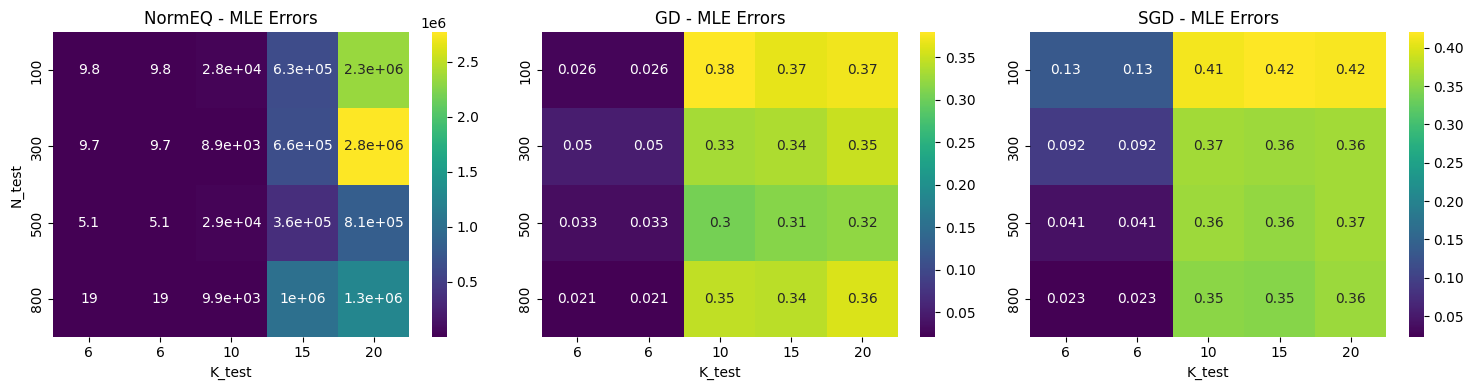

In [ ]:
print(f"\nOptimal K = {optimal_K}\n")
plot_error_heatmaps_mle(errors_mle["NormEQ"], errors_mle["GD"], errors_mle["SGD"], same_colorbar=False)

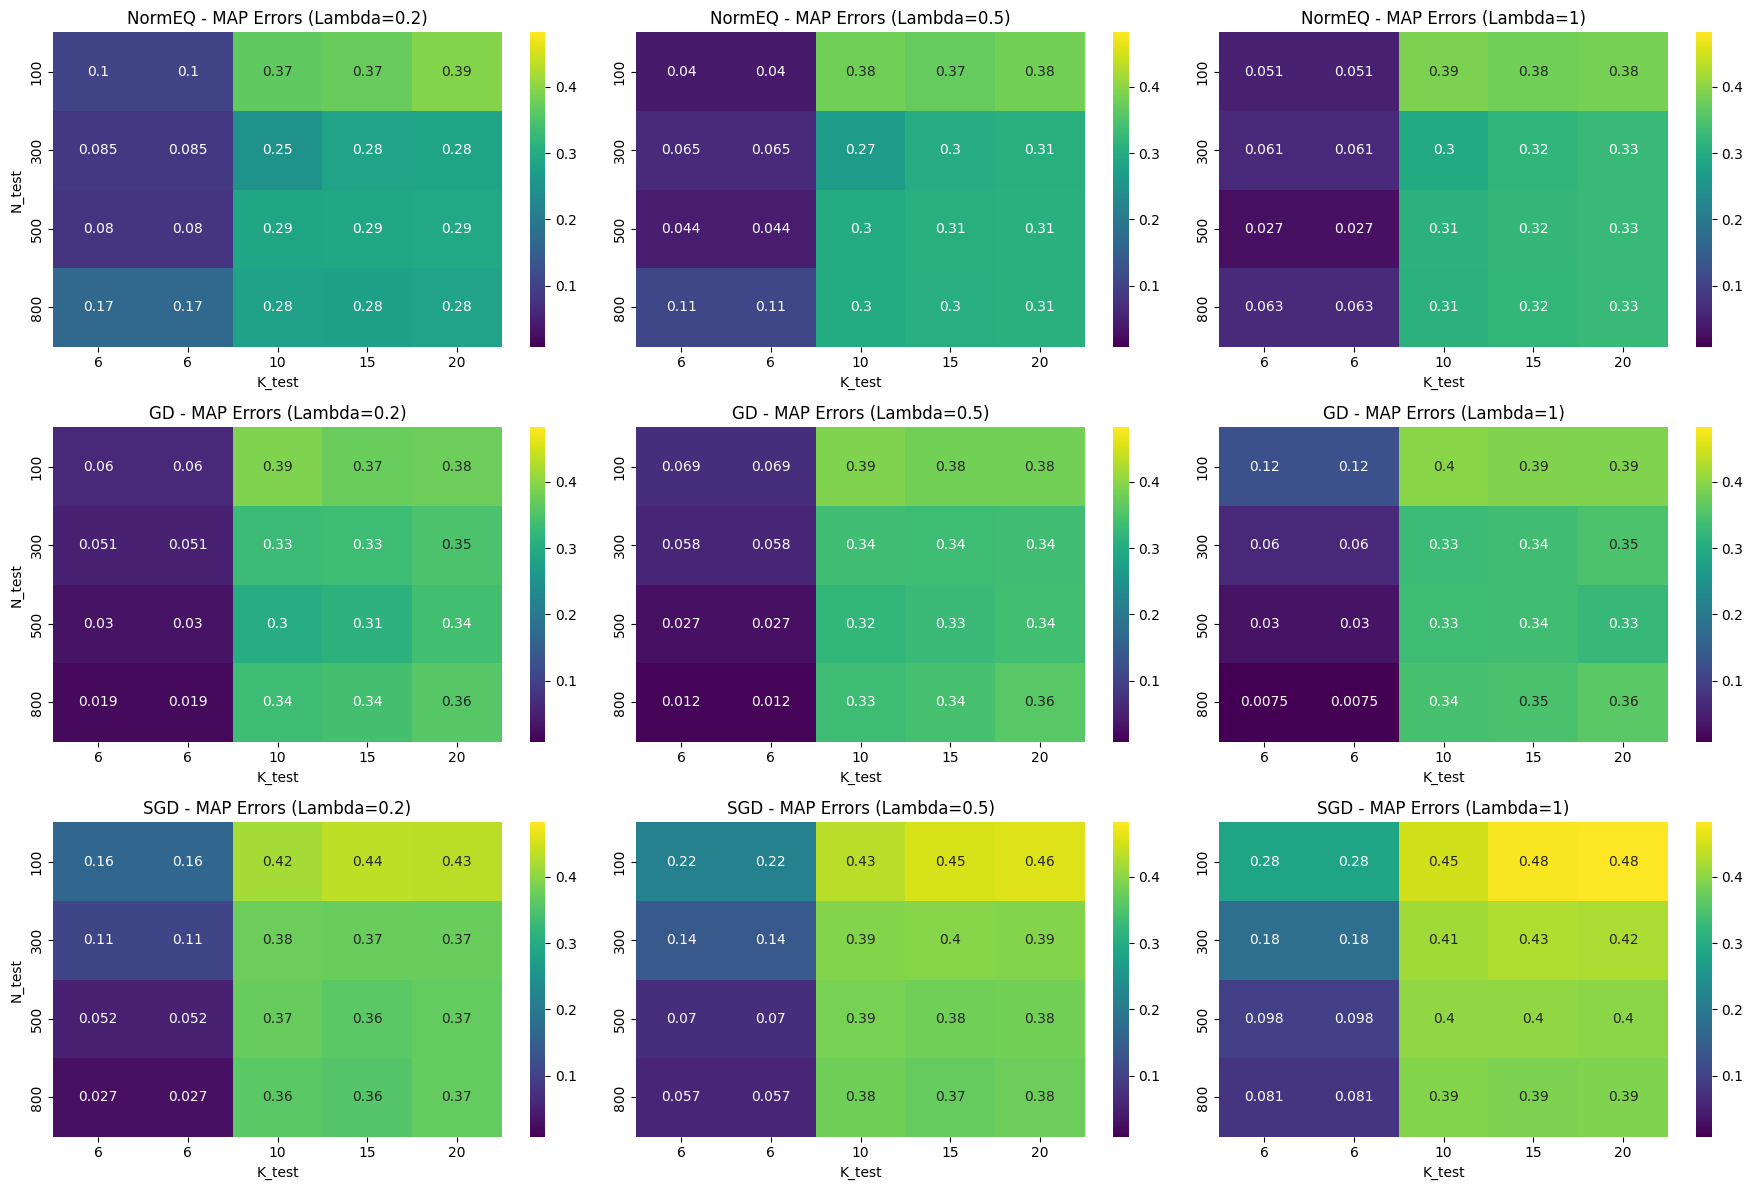

In [ ]:
plot_error_heatmaps_map(errors_map["NormEQ"], errors_map["GD"], errors_map["SGD"], lambda_to_test, same_colorbar = True)

By looking at these results we can deduce the following:
- **Optimization methods**: normal equations seem to be the most prone to ovefitting for high values of K. GD and SGD seem to be much more "resistant" to overfitting compared to optimization with normal equations.

- **Size of the training set**: A bigger training set (mostly when there is little/not regularization) is not always benefical for small values of K, but they help mitigate overfitting for big K.

- **Lambda values**: as already observed from the plots, a regularization term is crucial for mitigating overfitting, even though different values of lambda do not show significant improvement with respect to each other.

## Regression on Poisson Distribution

4) Repeat the first point of the homework by setting

$$
y^{i} \sim Poi({y|θ_{true, 1}+θ_{true, 2}x^i+...+θ_{true, K}(x^i)^{K-1}}) \quad ∀ i = 1,...,N
$$

Where $Poi(y|λ)$ is the Poisson distribution with parameter λ (you can find the Python function to do
that), such that

$$
Poi(y|λ)=\frac{λ^ye^{-y}}{y!}
$$

And consequently,

$$
p_θ(y|x) = Poi(y|θ_1 + θ_2x^i + ··· + θ_K(x^i)^{K−1})
$$

In [ ]:
def create_dataset(N, K, train_size=0.8, a=0, b=1):
    theta_true = np.ones((K,))

    N_train = round(N * train_size)
    X = np.random.uniform(low=a, high=b, size=N)

    Y = np.random.poisson(vander(X, K) @ theta_true)

    X_train, Y_train, X_test, Y_test = split(X, Y, N_train)

    return X_train, Y_train, X_test, Y_test


In [ ]:
K = 6                #int(input("Choose the value for K: "))
a = 0                 #int(input("Choose the value for a: "))
b = 1                 #int(input("Choose the value for b: "))
N = 300               #int(input("Choose the value for N: "))

theta_true = np.ones((K,))
X_train, Y_train, X_test, Y_test = create_dataset(N, K, train_size = 0.8)

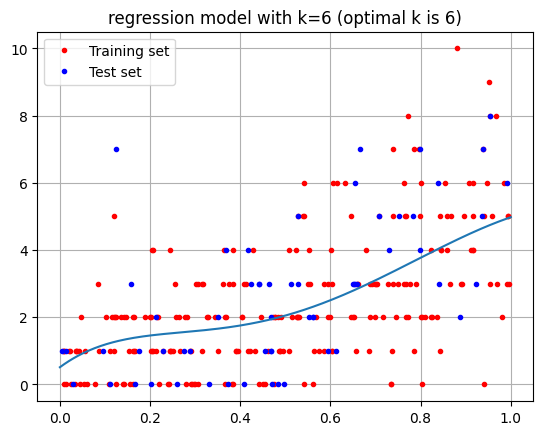

In [ ]:
optimization_method = {"NormEQ": 0, "GD": 1, "SGD": 2}
GD_parameters = {"tolf": 1e-5, "tolx": 1e-5, "max_iterations": 100, "alpha": 1e-2, "backtrack": True}
SGD_parameters = {"batch_size": 5, "n_epochs": 15, "alpha": 1e-2}

K_to_test = [6]
plot_test_set = True
opt_method = optimization_method["NormEQ"]

for k_test in K_to_test:
  theta_test = MLE_solution((X_train, Y_train), k=k_test, optimization_method=opt_method, f=f_MLE, grad_f=grad_f_MLE, gd_parameters=GD_parameters, sgd_parameters=SGD_parameters)
  plot_regression_model_mle((X_train, Y_train), k_test, theta_test, a=a, b=b, points=N, plot_test_set=plot_test_set, T=(X_test, Y_test), title=f"regression model with k={k_test} (optimal k is {K})")


Optimal K is 6


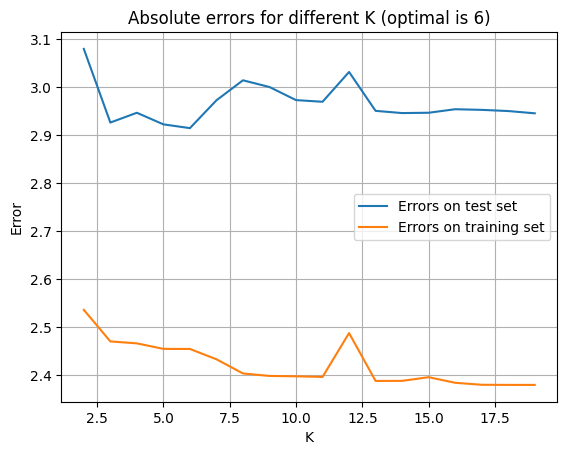

In [ ]:
optimization_method = {"NormEQ": 0, "GD": 1, "SGD": 2}
GD_parameters = {"tolf": 1e-5, "tolx": 1e-5, "max_iterations": 100, "alpha": 1e-2, "backtrack": True}
SGD_parameters = {"batch_size": 5, "n_epochs": 15, "alpha": 1e-2}

K_to_test = range(2,20)
opt_method = optimization_method["NormEQ"]

training_errors = []
test_errors = []

print("Optimal K is", K)
for k_test in K_to_test:
  theta_test = MLE_solution((X_train, Y_train), k=k_test, optimization_method=opt_method, f=f_MLE, grad_f=grad_f_MLE, gd_parameters=GD_parameters, sgd_parameters=SGD_parameters)

  test_errors.append(abs_error((X_test, Y_test), k_test, theta_test))
  training_errors.append(abs_error((X_train, Y_train), k_test, theta_test))

plot_test_vs_training_error(test_errors, training_errors, K_to_test, K)

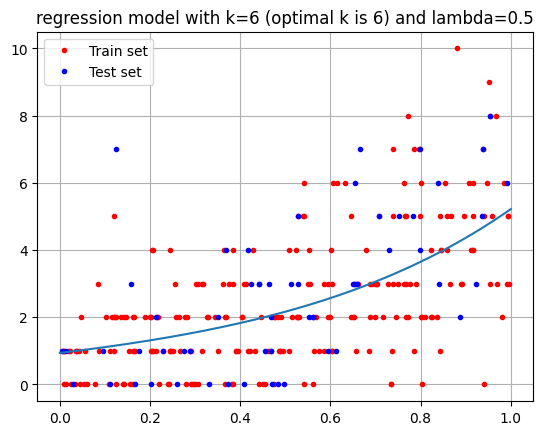

In [ ]:
optimization_method = {"NormEQ": 0, "GD": 1, "SGD": 2}
GD_parameters = {"tolf": 1e-5, "tolx": 1e-5, "max_iterations": 100, "alpha": 1e-2, "backtrack": True}
SGD_parameters = {"batch_size": 5, "n_epochs": 15, "alpha": 1e-2}

lambda_to_test = [0.5]
K_to_test = [6]
plot_test_set = True
opt_method = optimization_method["NormEQ"]


for k_test in K_to_test:
  for l in lambda_to_test:
    theta_test = MAP_solution((X_train, Y_train), k=k_test, lambd=l, optimization_method=opt_method, f=f_MAP, grad_f=grad_f_MAP, gd_parameters=GD_parameters, sgd_parameters=SGD_parameters)
    plot_regression_model_map((X_train, Y_train), k_test, theta_test, a=a, b=b, points=N, plot_test_set=plot_test_set, T=(X_test, Y_test), title=f"regression model with k={k_test} (optimal k is {K}) and lambda={l}")


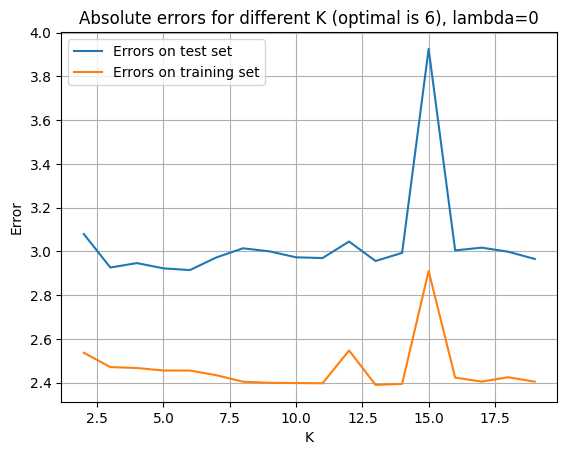

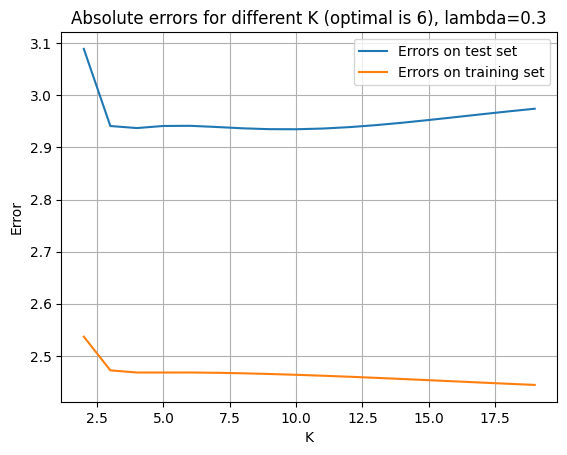

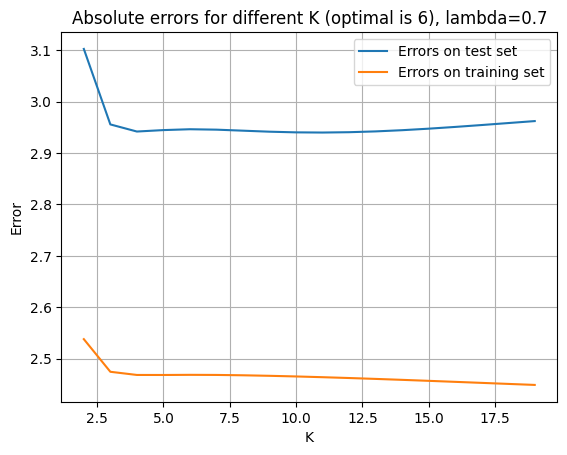

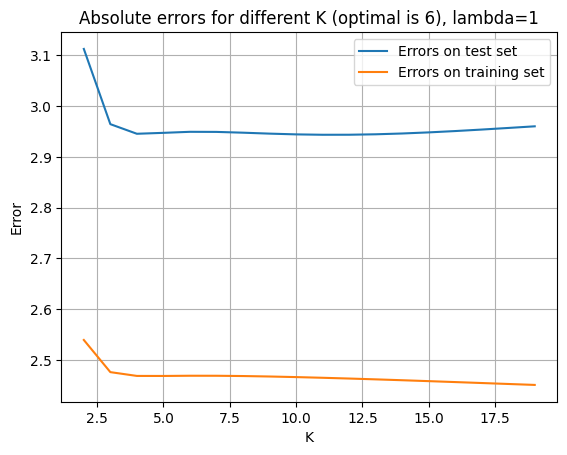

In [ ]:
optimization_method = {"NormEQ": 0, "GD": 1, "SGD": 2}
GD_parameters = {"tolf": 1e-5, "tolx": 1e-5, "max_iterations": 100, "alpha": 1e-2, "backtrack": True}
SGD_parameters = {"batch_size": 5, "n_epochs": 15, "alpha": 1e-2}

lambda_to_test = [0, 0.3, 0.7, 1]
K_to_test = range(2,20)
plot_test_set = True
opt_method = optimization_method["NormEQ"]


for l in lambda_to_test:
  test_errors = []
  training_errors = []
  for k_test in K_to_test:
    theta_test = MAP_solution((X_train, Y_train), k=k_test, lambd=l, optimization_method=opt_method, f=f_MAP, grad_f=grad_f_MAP, gd_parameters=GD_parameters, sgd_parameters=SGD_parameters)

    test_errors.append(abs_error((X_test, Y_test), k_test, theta_test))
    training_errors.append(abs_error((X_train, Y_train), k_test, theta_test))

  plot_test_vs_training_error(test_errors, training_errors, K_to_test, K, l)
  print()

5) Compute the MLE and MAP losses for this choice of $p_θ(y|x)$ and repeat the experiments in the previous points.


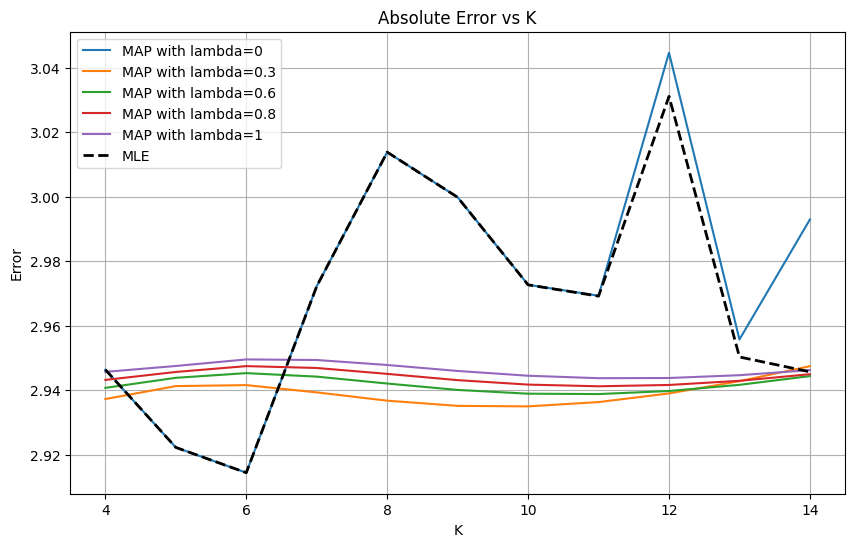

In [ ]:
optimization_method = {"NormEQ": 0, "GD": 1, "SGD": 2}
GD_parameters = {"tolf": 1e-5, "tolx": 1e-5, "max_iterations": 100, "alpha": 1e-2, "backtrack": True}
SGD_parameters = {"batch_size": 5, "n_epochs": 15, "alpha": 1e-2}

opt_method = optimization_method["NormEQ"]
lambda_to_test = [0, 0.3, 0.6, 0.8, 1]
K_to_test = range(4,15)
errors_map = {l: [] for l in lambda_to_test}
errors_mle = []

for k_test in K_to_test:
  theta_mle = MLE_solution((X_train, Y_train), k=k_test, optimization_method=opt_method, f=f_MLE, grad_f=grad_f_MLE, gd_parameters=GD_parameters, sgd_parameters=SGD_parameters)
  errors_mle.append(abs_error((X_test, Y_test), k_test, theta_mle))

  for l in lambda_to_test:
    theta_map = MAP_solution((X_train, Y_train), k=k_test, lambd=l, optimization_method=opt_method, f=f_MAP, grad_f=grad_f_MAP, gd_parameters=GD_parameters, sgd_parameters=SGD_parameters)
    errors_map[l].append(abs_error((X_test, Y_test), k_test, theta_map))

# Plotting
plt.figure(figsize=(10, 6))
for l, errors in errors_map.items():
  plt.plot(K_to_test, errors, label=f'MAP with lambda={l}')

plt.plot(K_to_test, errors_mle, label='MLE', color='black', linewidth=2, linestyle='--')
plt.title('Absolute Error vs K')
plt.xlabel('K')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
optimal_K = K

N_to_test = [100, 300, 500, 800]
lambda_to_test = [0.2, 0.5, 1]
K_to_test = [optimal_K, 10, 15, 20]

GD_parameters = {"tolf": 1e-5, "tolx": 1e-5, "max_iterations": 200, "alpha": 1e-2, "backtrack": True}
SGD_parameters = {"batch_size": 5, "n_epochs": 20, "alpha": 1e-2}

errors_mle = { opt_method: { n:{} for n in N_to_test } for opt_method in optimization_method.keys() }
errors_map = { opt_method: {n:{ k: {} for k in K_to_test } for n in N_to_test } for opt_method in optimization_method.keys() }

total_iterations = len(optimization_method) * len(N_to_test) * len(K_to_test) * len(lambda_to_test)
with tqdm(total=total_iterations, desc="Computing errors for each combination") as pbar:
  for N_test in N_to_test:
    SGD_parameters["batch_size"] = N_test//10

    X_train_new, Y_train_new, _, _ = create_dataset(N_test, optimal_K, train_size = 1) # train_size = 1, hence N ==  N_train

    for opt_method_name, opt_method in optimization_method.items():

            for k_test in K_to_test:
                theta_test = MLE_solution((X_train_new, Y_train_new), k=k_test, optimization_method=opt_method, f=f_MLE, grad_f=grad_f_MLE, gd_parameters=GD_parameters, sgd_parameters=SGD_parameters)
                errors_mle[opt_method_name][N_test][k_test] = theta_error(theta_test, theta_true)

                for l in lambda_to_test:
                    theta_test = MAP_solution((X_train_new, Y_train_new), k=k_test, lambd=l, optimization_method=opt_method, f=f_MAP, grad_f=grad_f_MAP, gd_parameters=GD_parameters, sgd_parameters=SGD_parameters)
                    errors_map[opt_method_name][N_test][k_test][l] = theta_error(theta_test, theta_true)

                    pbar.update(1)

Computing errors for each combination: 100%|██████████| 144/144 [00:29<00:00,  4.80it/s]



Optimal K = 6



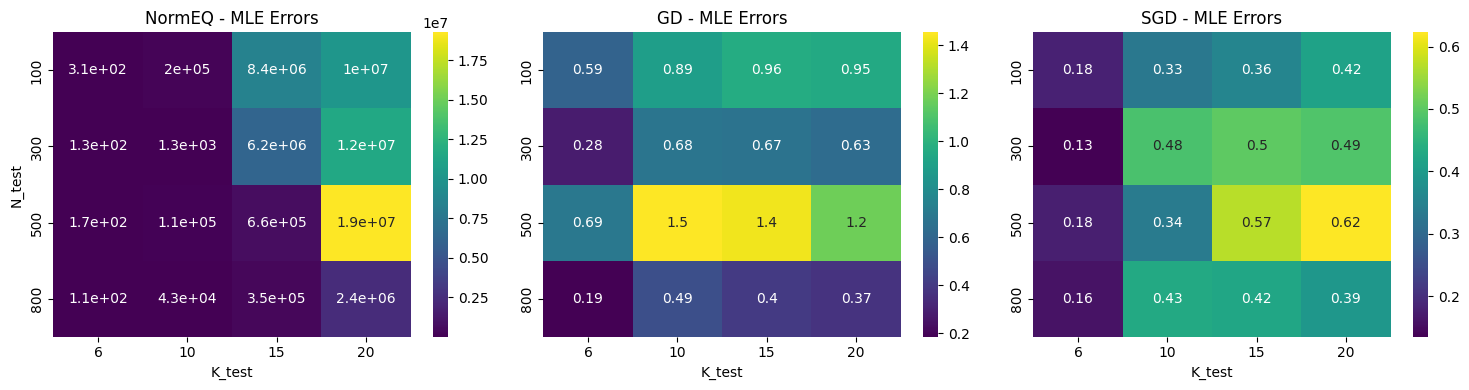

In [ ]:
print(f"\nOptimal K = {optimal_K}\n")
plot_error_heatmaps_mle(errors_mle["NormEQ"], errors_mle["GD"], errors_mle["SGD"], same_colorbar=False)


Optimal K = 6



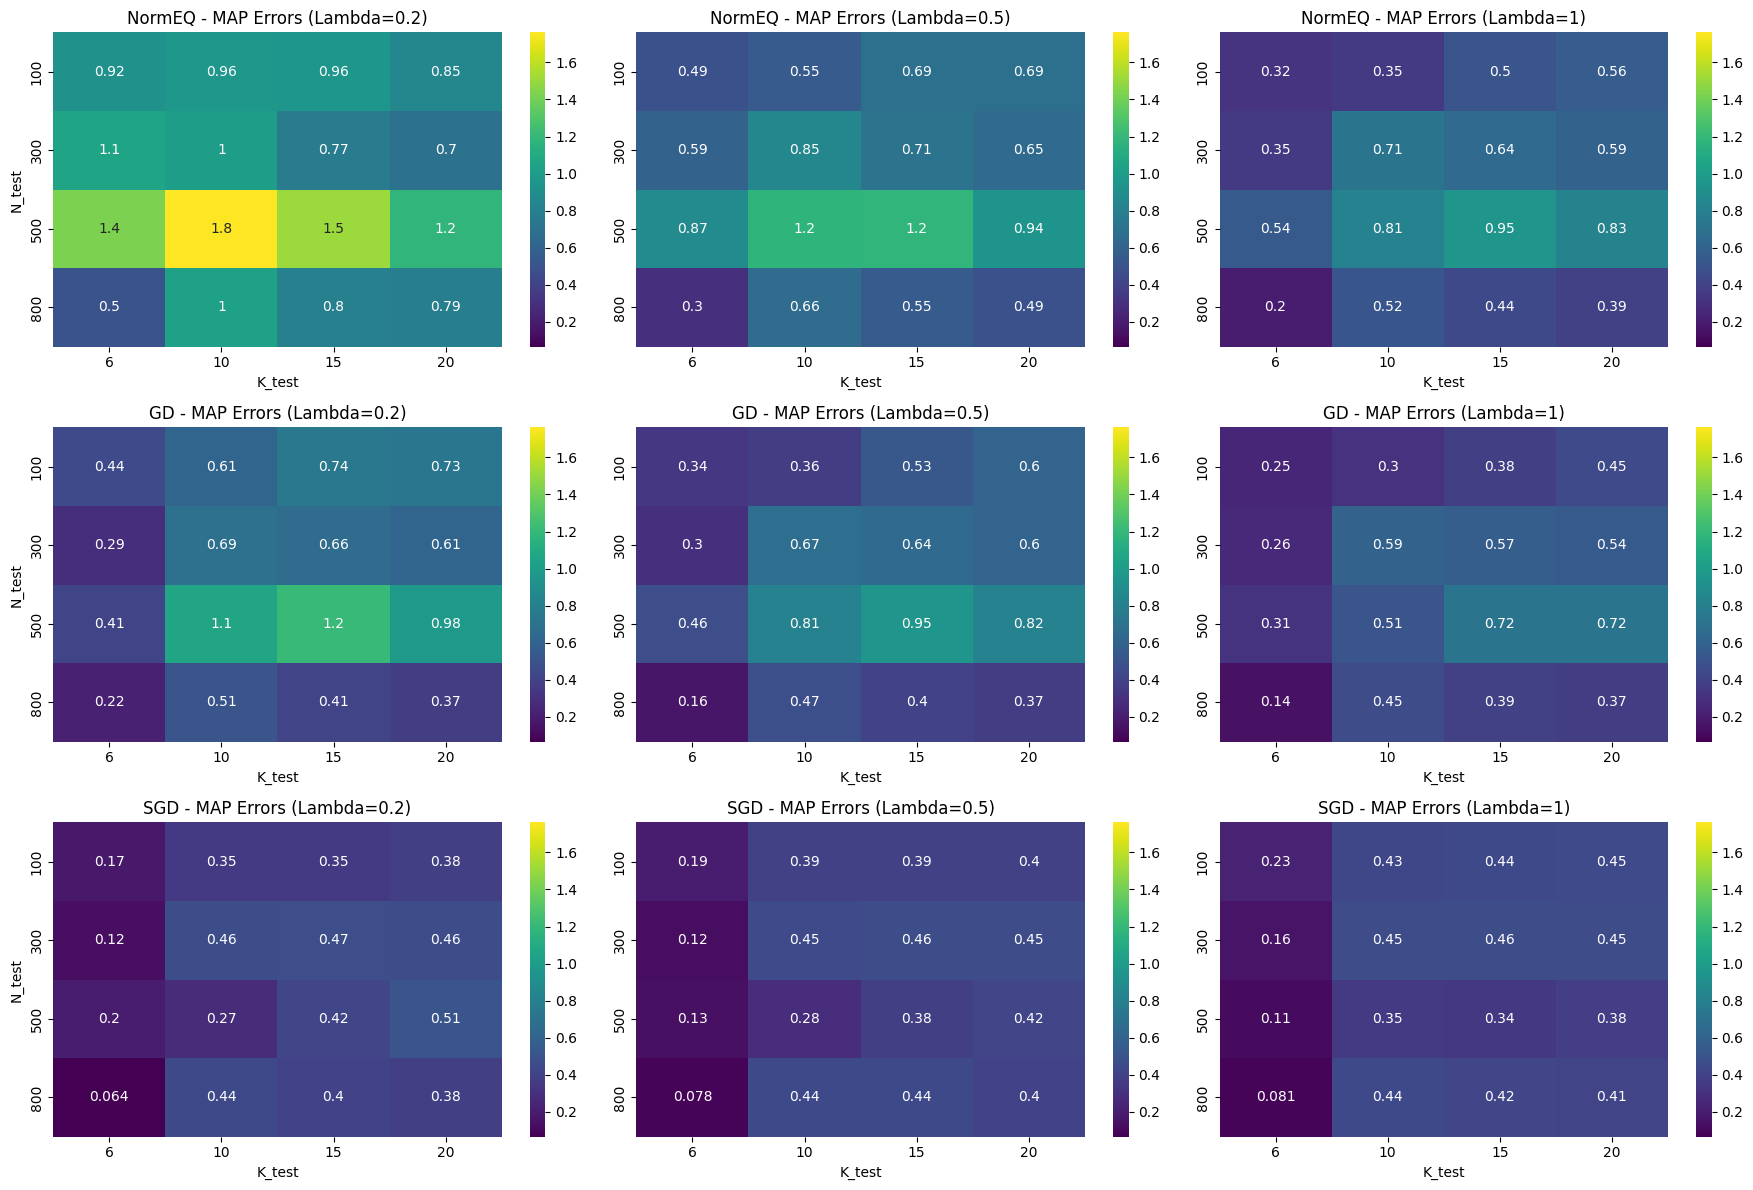

In [ ]:
print(f"\nOptimal K = {optimal_K}\n")
plot_error_heatmaps_map(errors_map["NormEQ"], errors_map["GD"], errors_map["SGD"], lambda_to_test, same_colorbar = True)

By looking at these results we can deduce the following:
- **Optimization methods**: normal equations seem to be the most prone to ovefitting for high values of K. GD and SGD seem to be much more "resistant" to overfitting compared to optimization with normal equations.

- **Size of the training set**: A bigger training set (mostly when there is little/not regularization) is not always benefical for small values of K, but they help mitigate overfitting for big K.

- **Lambda values**: as already observed from the plots, a regularization term is crucial for mitigating overfitting, even though different values of lambda do not show significant improvement with respect to each other.